# Runtime simulation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
from scipy import sparse
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
#warnings.warn('ignore')

In [5]:
%matplotlib inline

In [6]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/')
import simulate as sim

In [7]:
data_path = '/data/parameter_estimation/interferon_data/'

In [8]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

### Simulation

In [9]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [10]:
# Simluate the noise
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)



In [11]:
b = stats.lognorm.rvs(s=1, scale=2, size=1000)

In [12]:
b.mean()

3.5313530786911005

In [13]:
plt.hist(b, bins=100);

In [96]:
def simulate_data(N, n_genes=5):
    
    # NB parameters
    nb_mean = stats.lognorm.rvs(s=1, scale=2)
    nb_theta = 4
    
    qs = stats.beta.rvs(alpha, beta, size=N)
    
    nb = stats.nbinom.rvs(*convert_params(nb_mean,nb_theta), size=(N, n_genes))
    
    nb_obs = stats.binom.rvs(n=nb, p=np.vstack([qs for i in range(n_genes)]).T)
    
    # Create an ann data out of these
    obs_df = pd.DataFrame()
    obs_df['n_counts'] = [1e10 for i in range(N)]
    obs_df['cell_type'] = np.random.choice(['A', 'B'], size=N)
    obs_df.index = obs_df.index.astype(str)
    #values = sparse.csr_matrix(nb_obs)
    adata = sc.AnnData(
        nb_obs, 
        var=pd.DataFrame(index=['gene_' + str(i) for i in range(1, n_genes+1)]),
        obs=obs_df)
    
    return adata

def time_hypothesis_test(adata):
    
    imp.reload(scmemo)
    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=100000,
        beta=0.1)
    estimator.beta_sq = p_sq
    
    estimator.compute_observed_moments('A')
    estimator.compute_observed_moments('-A')
    estimator.compute_observed_moments('B')
    estimator.compute_observed_moments('-B')    
    estimator.estimate_parameters()
    
    return estimator.compute_confidence_intervals_1d(
        groups=['A','B'],
        groups_to_compare=[('A', 'B')],
        gene_tracker_count=None)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
num_cells = np.linspace(1000, 2e6, 10);

In [85]:
data = simulate_data(1000, n_genes=2)

In [ ]:
all_count_times = []
all_compute_times = []
avg_count_times = np.zeros(num_cells.shape[0])
avg_compute_times = np.zeros(num_cells.shape[0])
num_trials=50
for idx, N in enumerate(num_cells):
    print('On cell count', N, 'and idx', idx) 
    count_times = np.zeros(num_trials)
    compute_Times
    for trial in range(num_trials):
        data = simulate_data(int(N), n_genes=2)
        times[trial],  = time_hypothesis_test(data)
    all_times.append(times.copy())
    avg_times[idx]  = times.mean()

In [101]:
count_times = []
compute_times = []
num_trials = 5
for idx, N in enumerate(num_cells):
    print(N)
    data = simulate_data(int(N), n_genes=5)
    count_time, compute_time = time_hypothesis_test(data)
    count_times.append(count_time)
    compute_times.append(compute_time)

1000.0
223111.11111111112
445222.22222222225
667333.3333333334
889444.4444444445
1111555.5555555555
1333666.6666666667
1555777.777777778
1777888.888888889
2000000.0


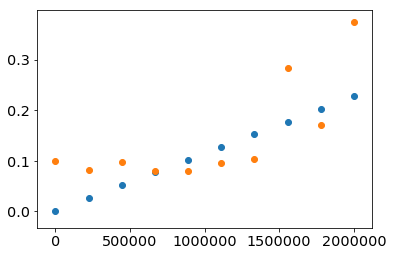

In [103]:
plt.scatter(num_cells, count_times/n_genes)
plt.scatter(num_cells, compute_times/n_genes)

In [79]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=data, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.beta_sq = p_sq

estimator.compute_observed_moments('A')
estimator.compute_observed_moments('-A')
estimator.compute_observed_moments('B')
estimator.compute_observed_moments('-B')    
estimator.estimate_parameters()

estimator.compute_confidence_intervals_1d(
    groups=['A','B'],
    groups_to_compare=[('A', 'B')],
    gene_tracker_count=None)

There was 4 unique values in A
There was 5 unique value in B
it took 0.005694150924682617 to count
it took 0.003168821334838867 to compute/store
There was 5 unique values in A
There was 3 unique value in B
it took 0.005237579345703125 to count
it took 0.0033769607543945312 to compute/store


In [63]:
def time_hypothesis_test(adata):
    
    
    
    imp.reload(scmemo)
    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=100000,
        beta=0.1)
    estimator.beta_sq = p_sq
    
    estimator.compute_observed_moments('A')
    estimator.compute_observed_moments('-A')
    estimator.compute_observed_moments('B')
    estimator.compute_observed_moments('-B')    
    estimator.estimate_parameters()
    
    start = time.time()
    estimator.compute_confidence_intervals_1d(
        groups=['A','B'],
        groups_to_compare=[('A', 'B')],
        gene_tracker_count=None)
    
    return time.time() - start

In [71]:
num_cells = np.logspace(2, 6, 5);

In [72]:
all_times = []
avg_times = np.zeros(num_cells.shape[0])
#num_trials = 5
for idx, N in enumerate(num_cells):
    print('On cell count', N, 'and idx', idx)
    data = simulate_data(int(N), n_genes=2)
    avg_times[idx] = time_hypothesis_test(data)
    
    times = np.zeros(num_trials)
    for trial in range(num_trials):
        data = simulate_data(int(N), n_genes=)
        times[trial] = time_hypothesis_test(data)
    all_times.append(times.copy())
    avg_times[idx]  = times.mean()

On cell count 100.0 and idx 0


/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


On cell count 1000.0 and idx 1
On cell count 10000.0 and idx 2
On cell count 100000.0 and idx 3
On cell count 1000000.0 and idx 4


In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [22]:
%matplotlib inline

Text(0.5, 0, '# cells')

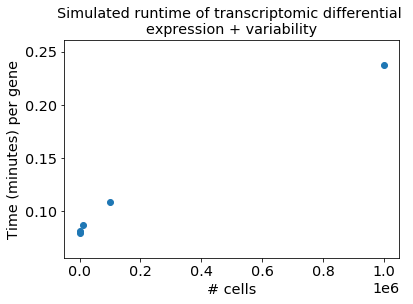

In [73]:
plt.scatter(num_cells, avg_times/n_genes)
plt.ticklabel_format(axis='x', style='sci', scilimits=(2, 6))
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Time (minutes) per gene');
plt.xlabel('# cells')
#plt.savefig('simulated_sublinear_runtime_more.pdf', bbox_inches='tight')

#plt.plot(num_cells[10:-10], smooth(times, 10)[10:-10], lw=5)

### Interferon data

In [158]:
ifn_num_cells = np.array([100, 500, 1000, 2000, 3000, 5000, 10000, 20000])
ifn_times = np.array([
 20.869556665420532,
 35.29805541038513,
 38.040297746658325,
 46.348387002944946,
 58.43357753753662,
 87.58861637115479,
 142.3105809688568,
 222.7312273979187])

In [182]:
print(list(zip(num_cells, times)))

[(100.0, 6.929297208786011), (215.44346900318845, 12.625685453414917), (464.15888336127773, 6.224719762802124), (1000.0, 10.965573787689209), (2154.4346900318824, 9.975577116012573), (4641.588833612777, 14.064831018447876), (10000.0, 31.910074710845947), (21544.346900318822, 88.86108231544495), (46415.888336127726, 234.89731240272522), (100000.0, 339.7262473106384)]


In [184]:
sim_num_cells = np.array([   100.        ,    215.443469,  21544.34690032,
        46415.88833613, 100000.        ])
sim_times = np.array([
    6.92929721,  12.62568545,  88.86108232,
       234.8973124 , 339.72624731
])
sim_times = sim_times*(20.869556665420532/6.92929721)

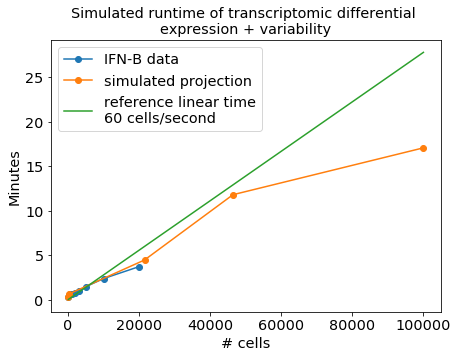

In [195]:
plt.figure(figsize=(7, 5))
plt.plot(ifn_num_cells, ifn_times/60, '-o', label='IFN-B data')
plt.plot(sim_num_cells, sim_times/60, '-o', label='simulated projection')
plt.plot(sim_num_cells, sim_num_cells/60/60, label='reference linear time\n60 cells/second')
plt.legend()
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig('simulated_sublinear_runtime.pdf', bbox_inches='tight')

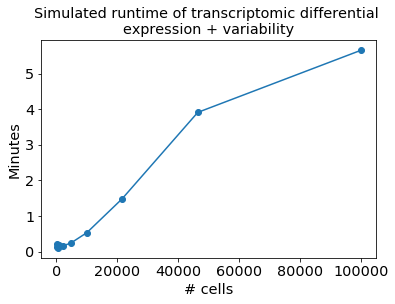

In [194]:
plt.plot(num_cells, times/60, '-o', label='runtime')
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/simulated_sublinear_runtime.pdf', bbox_inches='tight')

In [ ]:
plt.plot(times, np.array(perm_times)/60, '-o', label='runtime')
plt.plot(Ns, np.array(Ns)/60/60, label='ref. linear time\n60 cells/second')
plt.legend()
plt.title('Runtime of simulated transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/sublinear_runtime.pdf', bbox_inches='tight')